Presenting the results from the galaxy type classification. 
First I load the data. 

In [4]:
#standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import sys
import os
import time
import random as random
from astropy.io import fits
#torch functions
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
#sklearn helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,f1_score, log_loss
#xgboost for comparison
from xgboost import XGBClassifier
#logistic regression for comparison 
from sklearn.linear_model import LogisticRegression
from functions_ml import *

Below I get the data, which is produced by the program get_zoo_galaxies.py.  The is applied  43 times and thus gets data from 43 fields. This fields cover the area from 310 (-50) degree to 60 degree in right ascension with a height from -1.26 to +1.26  degree in Declination. 

The data consist of two pieces, firstly the images, which were saved as 4 dimensions (1 dimension x of image, second y of image, third channels, forth image in order or batch on torch language) numpy arrays, because torch needs 4d arrays, even when as here only a single channel exist. The image are rdeep images from http://research.iac.es/proyecto/stripe82/pages/data.php
This channel is the channel combination with the highest snr. Secondly information on each iamges is loaded as data frame, that are in particular the calseses spiral and elliptical which are bollean and exclusive here. There are citizen zoo classifications from the zoo projects. Only rather certain ones I included here, but there is no 100% certainty. 

In [9]:
#getting the list of images
myPath='/home/tobias/ml-testing/astr-images'
list_images=[f for f in os.listdir(myPath) 
    if f.endswith('_ell_spiral_im.npy') ]
list_images.sort()
#getting the list of tables 
list_tables=[f for f in os.listdir(myPath) 
    if f.endswith('_ell_spiral_table.csv')]
list_tables.sort()

I combine the images and the data frames, with the classifications and more meta data. 

In [11]:
#images
cutouts=comb_nump_4d(list_images)
#dataframes 
list_df=[]
for i in range(len(list_tables)):
    i=pd.read_csv(list_tables[i])
    list_df.append(i)  
print(f"number of tables is {len(list_df)}") 
df=pd.concat(list_df,ignore_index=True)
print(f"shape of combined data frame {df.shape}")
print(f"shape of image file is {cutouts.shape}")

number of tables is 43
shape of combined data frame (7875, 51)
shape of image file is (43, 43, 1, 7875)


The images and the classification data has the same lengths. Now I am looking on classes.

In [12]:
print(df.spiral.value_counts())

1    5766
0    2109
Name: spiral, dtype: int64


Next I display some examples. There arer two classes of galaxies, elliptical and Spiral.

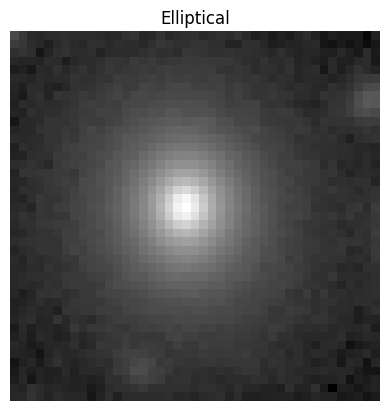

In [26]:
x=0
plt.axis('off')
plt.title(f"Elliptical")
plt.imshow(abs(cutouts[:,:,0,x])**0.25,cmap=cm.gray, interpolation='nearest')

This elliptical is rather round, but others are more elongated but never exteremly. 

Spiral look rather different dependent on the angle, they are viwed on. 

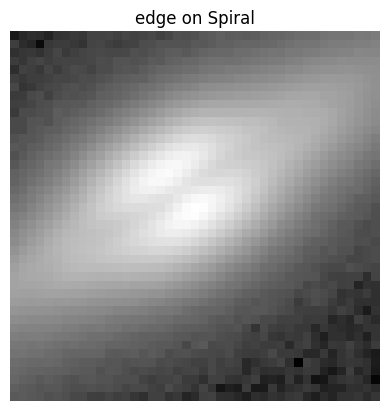

In [61]:
x=7870
plt.axis('off')
plt.title(f"edge on Spiral")
plt.imshow(abs(cutouts[:,:,0,x])**0.25,cmap=cm.gray, interpolation='nearest')

The dark strip in the center is not always visible in practice. 

The name giving spiral structure is visible face on. 

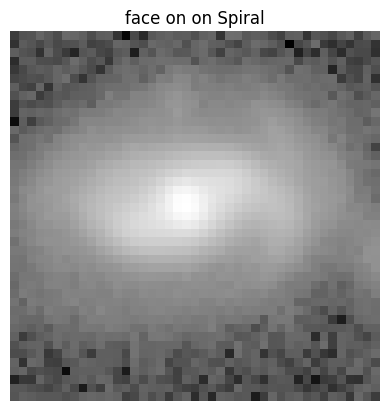

In [58]:
x=18
plt.axis('off')
plt.title(f"face on on Spiral")
plt.imshow(abs(cutouts[:,:,0,x])**0.125,cmap=cm.gray, interpolation='nearest')

However, some spirals only display other deviations from the simple structures of ellipticals, like rings.  

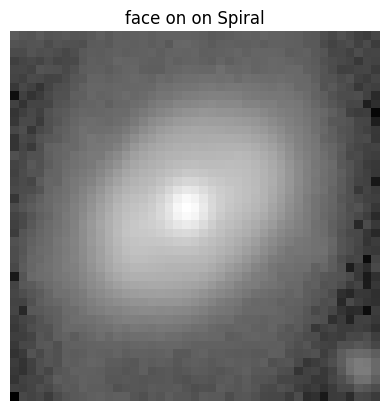

In [60]:
x=7874
plt.axis('off')
plt.title(f"face on on Spiral")
plt.imshow(abs(cutouts[:,:,0,x])**0.15,cmap=cm.gray, interpolation='nearest')

Thus, it is clear that there is a variation in structure between different examples of the same class. 

